# Homework 1 (Total Points: 175)



Learning Goals:
- Learn how to load a dataset and process it.
- Learn how to implement several IR methods (TFIDF, BM25, QL) and understand their weaknesses & strengths.
- Learn how to evaluate IR methods


**NOTE 1**: Only the code (`TODO: Implement this!` denotes these sections) is graded. The 'theory' questions in this assignment serve as a preparation for the exam and to facilitate a deeper understanding of the course content. These questions (denoted by `TODO: Answer this!`) have no points assigned to them, but **need** to be filled out before submission.  

**NOTE 2**: You can use the `nltk`, `numpy` and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. 

**NOTE 3**: The notebook you submit has to have the student ids, seperated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 

**NOTE 4**: Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  

---
Additional Resources: 
-  Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)


In [1]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.html import widgets
from collections import namedtuple

%matplotlib inline

/Users/Yke/Desktop/AI/Courses/IR1/venv/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Section 1: Text Processing (20 points)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 

The following cell downloads the dataset and unzips it to a local directory

In [2]:
def download_dataset(folder_path = "./datasets/"):
    
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

You can see a brief description of each file in the dataset by looking at the README file

In [3]:
##### Read the README file 
!cat ./datasets/README
#####

Files in this directory with sizes:
          0 Jun 19 21:01 README

    2187734 Jun 19 20:55 cacm.all              text of documents
        626 Jun 19 20:58 cite.info             key to citation info
                                                (the X sections in cacm.all)
       2668 Jun 19 20:55 common_words           stop words used by smart
       2194 Jun 19 20:55 make_coll*             shell script to make collection
       1557 Jun 19 20:55 make_coll_term*        ditto (both useless without
                                                smart system)
       9948 Jun 19 20:55 qrels.text             relation giving
                                                    qid did 0 0
                                                to indicate dument did is
                                                relevant to query qid
      13689 Jun 19 20:55 query.text             Original text of the query


----
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available. 
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [4]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
!head -45 ./datasets/cacm.all
#####

.I 1
.T
Preliminary Report-International Algebraic Language
.B
CACM December, 1958
.A
Perlis, A. J.
Samelson,K.
.N
CA581203 JB March 22, 1978  8:28 PM
.X
100	5	1
123	5	1
164	5	1
1	5	1
1	5	1
1	5	1
205	5	1
210	5	1
214	5	1
1982	5	1
398	5	1
642	5	1
669	5	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
1	6	1
165	6	1
196	6	1
196	6	1
1273	6	1
1883	6	1
324	6	1
43	6	1
53	6	1
91	6	1
410	6	1
3184	6	1


---

Now, write a function to read in the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document

In [5]:
# TODO: Implement this! (4 points)
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/cacm" be default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (seperated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
    file_path = os.path.join(root_folder, 'cacm.all')
    with open(file_path, 'r') as f:
        docs = []
        title = ''
        abstract = ''
        in_title = False
        in_abstract = False
        for line in f:
            if line.startswith('.I '):
                doc_id = line.strip('\n').split('.I ')[1]
            if in_title and not line.startswith('.'):
                title += line
            if in_abstract and not line.startswith('.'):
                abstract += line
            if line.startswith('.T'):
                in_title = True
            if line.startswith('.W'):
                in_title = False
                in_abstract = True
            if (in_title or in_abstract) and (line.startswith('.B') or line.startswith('.A')):
                in_title = False
                in_abstract = False
                docs.append((int(doc_id),title+abstract))
                title = ''
                abstract = ''
    return docs

docs = read_cacm_docs()

In [6]:
##### 
assert len(docs) == 3204, "There should be exactly 3024 documents"
##### 

---

Next, let us read the queries. They are formatted similarly: 

In [7]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
!head -15 ./datasets/query.text
#####

.I 1
.W
 What articles exist which deal with TSS (Time Sharing System), an
operating system for IBM computers?
.N
 1. Richard Alexander, Comp Serv, Langmuir Lab (TSS)
 
.I 2
.W
 I am interested in articles written either by Prieve or Udo Pooch
.A
Prieve, B.
Pooch, U.
.N
 2. Richard Alexander, Comp Serv, Langmuir Lab (author = Pooch or Prieve)


---

Now, write a function to read in this file:

In [8]:
# TODO: Implement this! (3 points)
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" be default
        Returns: A list of 2-tuples: (query_id, query)
    """
    file_path = os.path.join(root_folder, 'query.text')
    with open(file_path, 'r') as f:
        queries = []
        query = ''
        in_query = False
        for line in f:
            if line.startswith('.I '):
                query_id = line.strip('\n').split('.I ')[1]
            if line.startswith('.A'):
                in_query = False
            if line.startswith('.N'):
                in_query = False
                queries.append((int(query_id),query))
                query = ''
            if in_query:
                query = query + line
            if line.startswith('.W'):
                in_query = True
    return queries
    
queries = read_queries()

In [9]:
##### 
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"
##### 

---

Read in the stop words:

In [10]:
!head ./datasets/common_words

a
about
above
accordingly
across
after
afterwards
again
against
all


In [11]:
# TODO: Implement this! (3 points)
def load_stopwords(root_folder = "./datasets"):
    """
    Load the stopwords
    Output: A set of stopwords
    """

    stopwords = set()
    file_path = os.path.join(root_folder, 'common_words')
    with open(file_path, 'r') as f:
        for line in f:
            stopwords.add(line.strip('\n'))
    return stopwords

stopwords = load_stopwords()
assert len(stopwords) == 428

--- 

We can now write some basic text processing functions. A first step is to tokenize the text. You may use any tokenizer available in the `nltk` library:

In [12]:
# TODO: Implement this! (5 points)
def tokenize(text):
    """
        Tokenize the text. 
        Input: text - a string
        Output: a list of tokens
    """
    return nltk.tokenize.word_tokenize(text)

In [13]:
#####
text = "the quick brown fox jumps over the lazy dog"
tokens = tokenize(text)
print(tokens)
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']


---

*Answer the following questions*: 
- Why is stemming necessary, in particular for IR?
    - *TODO: Answer this!* <br> 
    Depending on the language words can come in various forms (pre- and suffixes), while still carrying similar meanings (e.g. run, runs, ran, etc.). To do information retrieval we need to match similar information. Stemming removes most morphological information and keeps only the stem of a word, bringing words back to a more general form. This way, words can be more easily matched, and more relevant documents can be found, with less computations. <br><br>
    
- Is there any setting (domain, scenario, etc) in which stemming can hurt performance? Illustrate with an example
    - *TODO: Answer this!* <br>
    In some cases stemming leads to ambiguity (e.g. organization -> organ) and therefore irrelevant documents could be mistakenly selected. Moreover, stemming can hurt performance for high-accuracy domains, such as the chemical domain. When looking up article about a certain protein, stemming the protein might lead to returning articles that are about a similar protein but not that exact one.

Write a function to stem tokens. Again, you can use the `nltk` library for this

In [14]:
# TODO: Implement this! (5 points)
def stem_token(token):
    """
        Stem the given token, using any stemmer available from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    stemmer = nltk.stem.porter.PorterStemmer()
    return stemmer.stem(token)

In [15]:
####
print([stem_token(t) for t in tokens])
tokens_ = [
    'caresses', 'flies', 'dies', 'mules', 'denied',
    'died', 'agreed', 'owned', 'humbled', 'sized',
    'meeting', 'stating', 'siezing', 'itemization',
    'sensational', 'traditional', 'reference', 'colonizer',
    'plotted', "organization", "organ"]
print([stem_token(t) for t in tokens_])
####

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog']
['caress', 'fli', 'die', 'mule', 'deni', 'die', 'agre', 'own', 'humbl', 'size', 'meet', 'state', 'siez', 'item', 'sensat', 'tradit', 'refer', 'colon', 'plot', 'organ', 'organ']


---

*Answer the following questions*: 
- Another processing step (not done here) is to use n-grams. Illustrate why you would want to use n-grams in IR with an example.  
    - *TODO: Answer this!* <br>
N-grams can be used to bring order into the search. Instead of only looking at the presence of the query words individually in a document, one can use n-grams to match sequences. Similarly, n-grams can capture context information. For example if you are only interested in a specific kind of housing e.g. student housing, a bigram can better capture what documents might be relevant for you by not returning documents that only contain the word housing in a different context.
<br><br>

- Usage of n-grams exacerbates some problems ex. in bi-gram language models. What is this problem? Suggest one solution
    - *TODO: Answer this!* <br>
    One problem is that n-gram models increase the vocabulary size a lot. A larger vocabulary requires more computation, for example to build an inverted index, which can become a problem. Also, in general n-grams are highly sparse (the higher n, the sparser). This last problem could be addressed by applying "smoothing", i.e. distributing probability over rare/sparse occurences.
    

--- 

The following function puts it all together. Given a string, it tokenizes it, and processes it according to the flags that you set.

In [16]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

Let's create two sets of pre-processed documents

In [17]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text: stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 


We can now process the documents and queries according to the configuration specified above

In [18]:
####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))

####


--- 

## Section 2: Indexing (10 points)


A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### Building an index

---

In this assignment we will be using an index created in memory, since our dataset is tiny. To get started, build a simple index that maps simply counts the number of tokens present in a document. This index  is built using a python dictionary.

*Answer the following questions*:
- What is the time complexity of retrieving a list of documents from a python `dict` object? 
    - *TODO: Answer this!* <br> 
   To get an item (such as a list) from a python dict, the time complexity for the average case is $\mathcal{O}(1)$.
    <br><br>
- Consider the case with a 10 million documents. What is the time complexity of retrieval with an inverted index (assuming you can fit the entire index in memory)? (Hint: Consider length of a query $|q|$) 
    - *TODO: Answer this!* <br>
    To retrieve a document we need to look up each query word ==> $\mathcal{O}(|q|)$. <br><br>
- For a large enough collection, we cannot store an index in memory. How is this tackled in practice (briefly explain)? Comment on the time complexity. 
    - *TODO: Answer this!* <br>
    One can either do two-pass indexing or one-pass with merging. The first goes through the documents once and gathers statistics about the entire document corpus. Then, a template is created and filled in in the second pass. The second cuts the index off regularly and saves that part to disc. In the end all index parts are merged. <br><br>
- Mention a use-case in which a simple index (from word -> doc_id) might not suffice anymore. How would you modify the index to suit this use-case (if you can!)  
    - *TODO: Answer this!* <br>
    It would not suffice anymore when the frequency of a word is an important feature to a document, rather than only its (binary) occurance. That is the case if a word occurs almost in all documents, but in some cases more times than others. In that case we would modify the the index such that <br>word -> (doc_id, term_frequency).
    
Now, implement a function to build an index:

In [19]:
# TODO: Implement this! 10 points

from collections import defaultdict, Counter

def build_tf_index(documents):
    """
    Build an inverted index (with counts). The output is a dictionary which takes in a token
    and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
    Input: a list of documents - (doc_id, tokens) 
    Output: An inverted index. [token] -> [(doc_id, token_count)]
    """
    index = defaultdict(set)
    for doc_id, text in documents:
        word_counter = Counter(text)
        for word, token_count in word_counter.items():
            index[word].add((doc_id, token_count))
    return index
 
# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

# This function returns the correct index 
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

# This function correctly pre-processes the text given the index set
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)
    

--- 

## Section 3: Retrieval  (80 points)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- TF-IDF
- BM25
- Query Likelihood Models

--- 

### Ranking functions


Probably the simplest IR model is the Bag of Words (BOW) model. Implement a function that scores a query against a document using this model.   

Note that you can use either the count of the token or 'binarize' it i.e set the value equal to 1 if the token appears.   


**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

In [20]:
# TODO: Implement this! 10 points

def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note #1: You have to use the `get_index` function created in the previous cells
        Note #2: You can binarize the counts if you wish to
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    binarize = False
    index = get_index(index_set)
    query = preprocess_query(query, index_set)
    scores = defaultdict(lambda: 0.)
    
    for token in query:
        search_results = index[token]
        for document_id, score in search_results:
            scores[document_id] += 1. if binarize else float(score)
            
    ranking = list(scores.items())
    ranking.sort(key = lambda tup: tup[1], reverse=True)
    return ranking

*Answer the following questions*: 
- The BOW model is might not be a good choice for use in IR. Why? 
    - *TODO: Answer this!* <br>
    Each word is weighted the same in the BOW model. It does not take into account how often or rarely a word appears in all of the documents, even though some words are more informative than others (e.g. think about the small frequency of "junction" and large frequency of "report").

In [21]:
####
docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow = bow_search("report", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow)
####

BOW Results:
Rank 0(6.0): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(5.0): An Information Algebra - Phase I Report-Language\n...
Rank 2(3.0): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(2.0): Curriculum Recommendations for Graduate Profession...
Rank 4(2.0): Control Procedures for Data Communication-An ASA P...


Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

In [22]:
# TODO: Implement this! (5 points)
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency)
    """
    doc_freqs = defaultdict(lambda: 0.)
    for doc in documents:
        unique_tokens = set(doc)
        for token in unique_tokens:
            doc_freqs[token] += 1
    return doc_freqs

# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]

#helper function
def get_docs(index_set):
    return {
        1: doc_repr_1,
        2: doc_repr_2
    }[index_set]

Next, implement a function that computes a tf-idf score given a query.      

In [23]:
# TODO: Implement this! 10 points
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    df = get_df(index_set)
    
    scores = defaultdict(lambda: 0.)
    all_docs = get_docs(index_set)
    for token in query:
        search_results = index[token]
        idf = np.log(len(all_docs)/(df[token]+1e-9))
        for document_id, tf in search_results:
            if tf > 0:
                tf_td = 1 + np.log(tf) #from the slides
#                 tf_td = tf / len(docs[document_id-1][1]) #wikipedia
#                 tf_td = tf  #book
            else:
                tf_td = 0
            scores[document_id] += tf_td * idf 
    
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking
    

In [24]:
####
test_tfidf = tfidf_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf)
####

TFIDF Results:
Rank 0(1.1e+01): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(1e+01): An Information Algebra - Phase I Report-Language\n...
Rank 2(8.2): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(6.7): Curriculum Recommendations for Graduate Profession...
Rank 4(6.7): Control Procedures for Data Communication-An ASA P...


*Answer the following questions*: 
- It is generally not advisable to use the naive version of tf-idf. Why?
    - *TODO: Answer this!* <br>
    In the case where a term occurs, say, 10 times in a document does not necessarily mean that a document is ten times more relevant compared to an document with an occurance of 1 time. The naive version (where the score scales linearly with term frequency) assumes this is the case.
    <br><br>
- Illustrate with an example why using a sublinear scaling for TF is preferable in some cases.  
    - *TODO: Answer this!* <br>
    In the same example as illustrated above we could modify the tf-term such that the total score scales with the log of the term frequency, such that a document, containing a certain word 10 times more than an other document gets a score of only approx. 2 times higher.<br><br>

--- 

*Answer the following questions*: 
- An alternative way to compute a query<>document score is to vectorize both the query and document (where each dimension corresponds to a token), and compute a score. The score can be computed using a dot product between the query and the document vectors. Why is the cosine similary function a better choice, particularly in IR? 
    - *TODO: Answer this!* <br>
    Take the example of a query size of 3, and 2 candidate documents A and B. Document A contains all words of the query at least once, up to a few times. Document B contains one word of the query, but many times. If we take the dot product to compute the scores, B might come at higher ranked than A, even though A contains all words of the query. We are therefore less interested in quantity, but rather in quality, or similarity of the query-document pair, so regardless of how ofter terms are present. The cosine method takes this into account, as it normalizes each vector before taking the dot product (equivalant: normalizes the result) and returns values between -1 and 1. Essentially the cosine method only measures the angle between two vectors. <br><br>
    
- What is the time complexity of a search if we are using the vector space method mentioned in the previous question? What is the time complexity if we're using an index (assume that it fits in memory)? Assume $N$ is the number of documents and $|q|$ is the length of a query. 
    - *TODO: Answer this!* <br>
    In the worst case, if the query words are in all documents, you would have to consider each document for each query word, resulting in a complexity of $\mathcal{O}( N\cdot|q|)$. If you use the vector space method, you would just have to compare the query vector with all document vectors, resulting in a complexity of $\mathcal{O}( N)$.
    

--- 

#### Query Likelihood Models

In this section you will implement a simple query likelihood model. 

First, let use implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 

**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

--- 

*Answer the following questions*: 
- Write down the formula for computing the query likelihood, assuming a multinomial unigram language model. 
    - *TODO: Answer this!* <br>
        $$P(Q |D) = \prod^n_{i=1}(q_i|D),$$ with $q_i$ query word $i$ and $D$ the document.
        The max. likelihood estimate is given by:
        $$P(q_i|D) = \frac{\text{tf}(q_i,D)}{|D|},$$ with tf$(q_i,D)$ the frequency of $q_i$ in $D$ and $|D|$ the number of tokens in $D$.
    <br><br>
    
    
- What problem does this naive method have? Suggest a simple way to fix it.
    - *TODO: Answer this!* <br>
     One issue is that if a word in a query does not occur a document, the likelihood immediately becomes zero, even though the document could still be relevant. This problem can be addressed by applying smoothing, where probability is "distributed" over unseen occurences. Another problem is that for long queries, the probability estimate approaches zero, as numbers smaller than one are multiplied. This can be fixed by taking the log of the probabilies, such that (log) probabilies are summed instead of multiplied.
    <br><br>

In [25]:
####
def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [26]:

# TODO: Implement this! 15 points
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    log_prob = False #option to use log
    
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    scores = defaultdict(lambda: 0.) if log_prob else defaultdict(lambda: 1.)
    prob_zero = set()
    
    for token in query:
        search_results = index[token]
        not_seen = list(range(1,len(doc_lengths)+1))
        for document_id, tf in search_results:
            prob = tf/(doc_lengths[document_id])
            if log_prob:
                scores[document_id] += np.log(prob)
            else:
                scores[document_id] *= prob
            not_seen.remove(document_id)
        prob_zero.update(not_seen)
    for document_id in prob_zero:
        if log_prob:
            scores[document_id] = -1e9 #something very low
        else:
            scores[document_id] = 0.
    
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking

In [27]:
doc_lengths = get_doc_lengths(index_set=2)
for i in range(1,len(doc_lengths)+1):
    if doc_lengths[i] == 0:
        print("BITHCH")

In [28]:
####
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"NAIVE QL Results:")
print_results(test_naiveql)
####

NAIVE QL Results:
Rank 0(0.2): A Report Writer For COBOL...
Rank 1(0.2): A CRT Report Generating System...
Rank 2(0.2): ALGOL Sub-Committee Report - Extensions...
Rank 3(0.17): Supplement to the ALGOL 60 Report...
Rank 4(0.14): Report on the Algorithmic Language FORTRAN II...


Now, let's implement a (slightly more) complex QL model. This model should 'fix' the issue with the previous method. If your model requires hyperparameters, set a reasonable value. 

In [29]:
# TODO: Implement this! 20 points
def ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a appropriate QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    log_prob = False #option for log use
    lamb = .1
    
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    scores = defaultdict(lambda: 0.) if log_prob else defaultdict(lambda: 1.)
    cl = sum(doc_lengths.values()) #collection length
    
    for token in query: 
        search_results = index[token]
        cf = sum([tf for _, tf in search_results]) #collection frequency
        not_seen = list(range(1,len(doc_lengths)+1))
        for document_id, tf in search_results:
            prob = (1-lamb)*tf/doc_lengths[document_id] + lamb*cf/cl
            if log_prob:
                scores[document_id] += np.log(prob)
            else:
                scores[document_id] *= prob
            not_seen.remove(document_id)
        for document_id in not_seen:
            if log_prob:
                scores[document_id] += np.log(lamb*cf/cl)
            else:
                scores[document_id] *= lamb*cf/cl
            
    
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking

In [30]:
#### Test the QL model
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(0.18): A Report Writer For COBOL...
Rank 1(0.18): A CRT Report Generating System...
Rank 2(0.18): ALGOL Sub-Committee Report - Extensions...
Rank 3(0.15): Supplement to the ALGOL 60 Report...
Rank 4(0.13): Report on the Algorithmic Language FORTRAN II...

Rank 0(3.6e-08): A Report Writer For COBOL...
Rank 1(3.6e-08): A CRT Report Generating System...
Rank 2(3.6e-08): ALGOL Sub-Committee Report - Extensions...
Rank 3(5.8e-09): Supplement to the ALGOL 60 Report...
Rank 4(1.2e-09): Report on the Algorithmic Language FORTRAN II...


*Answer the following questions*: 
- What happens to the query likelihood for long queries? What is a simple fix for this issue?
    - *TODO: Answer this!* <br>
    The likelihoods become very small which can cause numerical instabilities for large queries due to the product over all query word probabilities (smaller than 1). Instead we can take the log likelihood, such that (log) probabilities are summed, instead of multiplied, which is more stable.


--- 

#### BM25

In this section, we will implement the widely used and hard to beat BM25 scoring function. 


In [31]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set):
    """
        Perform a search over all documents with the given query using BM25. 
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    k1 = 1.2
    k2 = 100.
    b  = 0.75
    
    query = preprocess_query(query, index_set)
    index = get_index(index_set)
    doc_lengths = get_doc_lengths(index_set)
    scores = defaultdict(lambda: 0.)
    dl_avg = np.mean(list(doc_lengths.values()))
    N = len(doc_lengths)
    
    for token in query: 
        search_results = index[token]
        qf = query.count(token) #query frequency
        ni = len(search_results) #num docs containing the token
        for document_id, tf in search_results:
            dl = doc_lengths[document_id]
            K = k1 * ((1-b) + b*dl/dl_avg)
            scores[document_id] += np.log((N-ni+.5)/(ni+.5)) * (k1+1)*tf/(K+tf) * (k2+1)*qf/(k2+qf)
    
    ranking = list(scores.items())
    ranking.sort(key= lambda tup: tup[1], reverse=True)
    return ranking

In [32]:
#### Test the BM25 model
test_bm25_results = bm25_search("report", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(6.2): A Report Writer For COBOL...
Rank 1(6.2): A CRT Report Generating System...
Rank 2(6.2): ALGOL Sub-Committee Report - Extensions...
Rank 3(6.2): Supplement to the ALGOL 60 Report...
Rank 4(6.1): Report on the Algorithmic Language FORTRAN II...




*Answer the following questions*: 
- Briefly explain how the BM25 model improves upon the tf-idf model.
    - *TODO: Answer this!* <br>
    It introduces document and query term weights that can be tuned which makes the model more flexible.

    
---

In [33]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

---
---

The widget below allows you to play with the search functions you've written so far. This can be used, for example, to answer some of the theory questions

In [34]:
# Set this to the function you want to test
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search
index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

## Section 4: Offline Evaluation (45 points)

Before we jump in and implement an algorithm for retrieval, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision
2. Recall
3. Mean Average Precision
4. Expected Reciprocal Rank

---
*Answer the following questions*: 
- What are the main limitations of an offline evaluation?
    - *TODO: Answer this!* <br>
    We can try to model users' interactions with the retrieved results, but the models will never be as good as evaluating directly on (actual) user interaction.

---

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [35]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


The first column is the `query_id` and the second column is the `document_id`. You can safely ignore the 3rd and 4th columns. Write a function to read in the file: 

In [36]:
# TODO: Implement this!
def read_qrels(root_folder = "./datasets/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary: query_id -> [list of relevant documents]
    """
    file_path = os.path.join(root_folder, 'qrels.text')
    data = np.loadtxt(file_path, dtype=int)
    qrels = defaultdict(lambda: [])
    for i, q in enumerate(data[:,0]):
        qrels[q].append(data[i,1])
    return qrels

qrels = read_qrels()

In [37]:
####
assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"
####

Now, implement the metrics below. 

**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


In [38]:
# TODO: Implement this! (10 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    TP = 0.
    FN = len(relevant_docs)
    for doc_id, score in results[:k]:
        if doc_id in relevant_docs:
            TP += 1
            FN -= 1
    return TP / (TP + FN)
    
    
# TODO: Implement this! (10 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    TP, FP = 0., 0. 
    for doc_id, score in results[:k]:
        if doc_id in relevant_docs:
            TP += 1
        else:
            FP += 1
    return TP / (TP + FP)

# TODO: Implement this! (10 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    p_sum = 0.
    N_relevant = len(relevant_docs)
    for k, (doc_id, score) in enumerate(results):
        if doc_id in relevant_docs:
            p_sum += precision_k(results, relevant_docs, k+1)
    return p_sum / N_relevant
            


# TODO: Implement this! (15 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
    """
    g = [1 if doc_id in relevant_docs else 0 for doc_id, _ in results]
    
    ERR = 0.
    p = 1.
    for i in range(len(g)):
        R = (2**g[i] - 1) / (2**np.max(g)+1)
        ERR += p * R/(i+1)
        p *= (1-R)
    return ERR
    
####

*Answer the following questions*: 
- What are the main drawbacks of precision & recall?
    - *TODO: Answer this!* <br>
    Given the precision and recall at a given cut-off $k$ we have no information about the top-$k$ ordering. For example, we do not (necessarily) know whether a relevant document is at the top rank for a $k>1$. If we want a model improve within the top-$k$ ranking, then precision & recall are not very informative metrics.<br><br>
    
- What problems with Precision@K does Average Precision solve? 
    - *TODO: Answer this!* <br>
    Using average precision and the precision @ k, we can approximate the top-$k$ ranking. If we want a model improve within the top-$k$ ranking, average precision would therefore be a useful and infromative metric to use, since it could "tell" to model where there is room for improvement.<br><br>
    
- The CACM dataset has *binary* relevance judgements. However, a more suitable way of assigning judgements is to use graded relevance. Mention a metric which might be more suitable for a graded relevance, and breifly explain why. 
    - *TODO: Answer this!* <br>
    ERR, since it models the likelihood that a user is satisfied at a given rank, and this measure is depent on the relevance of previous ranks. The higher the relevance at rank $k-1$, the lower the relevance at $k$, which is better taken into account for using graded relevances.<br><br>
    
- Consider a text processing step: stemming. What effect does this have on metrics? (Hint: Try changing the pre-processing config and try it out!)
    - *TODO: Answer this!* <br>
    In general less matches between words within queries and documents will be found, since un-stemmed words are more sparse than stemmed worse, which will probably result in more specific retrieved documents. But generally, the model will perform worse as it generalizes less.
    <br><br>

---

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [39]:
####
recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [40]:
####
def evaluate_search_fn(search_fn, metric_fn, index_set):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = np.zeros(len(qrels), dtype=np.float32)
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        results = search_fn(query, index_set)
        metrics[i] = metric_fn(results, relevant_docs)
    
    return metrics.mean()
####

In [41]:
#BUGS fixed

index_sets = {1, 2}

list_of_metrics = [
    ("ERR", err),
    ("MAP", average_precision),
    ("Recall@1",recall_at_1),
    ("Recall@5", recall_at_5),
    ("Recall@10", recall_at_10),
    ("Precision@1", precision_at_1),
    ("Precision@5", precision_at_5),
    ("Precision@10", precision_at_10)]

list_of_search_fns = [
    ("NaiveQL", naive_ql_search),
    ("QL", ql_search),
    ("BM25", bm25_search),
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search)
]


results = {}
for index_set in index_sets:
    results[index_set] = {}
    print(f"Index: {index_set}")
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = {}
        for metric_name, metric_fn in list_of_metrics:
            r = evaluate_search_fn(search_fn, metric_fn, index_set).mean()
            print(f"\t\tMetric: {metric_name}: {r}")
            results[index_set][search_fn_name][metric_name] = r
        print()

Index: 1
	Evaluating Search Function: NaiveQL
		Metric: ERR: 0.08005364239215851
		Metric: MAP: 0.059895262122154236
		Metric: Recall@1: 0.009386923164129257
		Metric: Recall@5: 0.04151767119765282
		Metric: Recall@10: 0.05137680098414421
		Metric: Precision@1: 0.11538461595773697
		Metric: Precision@5: 0.08461538702249527
		Metric: Precision@10: 0.05961538106203079

	Evaluating Search Function: QL
		Metric: ERR: 0.15118302404880524
		Metric: MAP: 0.10483800619840622
		Metric: Recall@1: 0.025907915085554123
		Metric: Recall@5: 0.08426275849342346
		Metric: Recall@10: 0.10536401718854904
		Metric: Precision@1: 0.25
		Metric: Precision@5: 0.16923077404499054
		Metric: Precision@10: 0.13076923787593842

	Evaluating Search Function: BM25
		Metric: ERR: 0.2522321939468384
		Metric: MAP: 0.2148122489452362
		Metric: Recall@1: 0.09149813652038574
		Metric: Recall@5: 0.16555224359035492
		Metric: Recall@10: 0.23610612750053406
		Metric: Precision@1: 0.4615384638309479
		Metric: Precision@5: 0.

## Section 5: Results and Analysis (20 points)

The `results` dictionary contains the results for all search functions we implemented. Plot the results in bar charts, with clear labels:

> PLOTS PER EVALUATION METHOD
(y axes represent values corresponding to what is specified in the title)


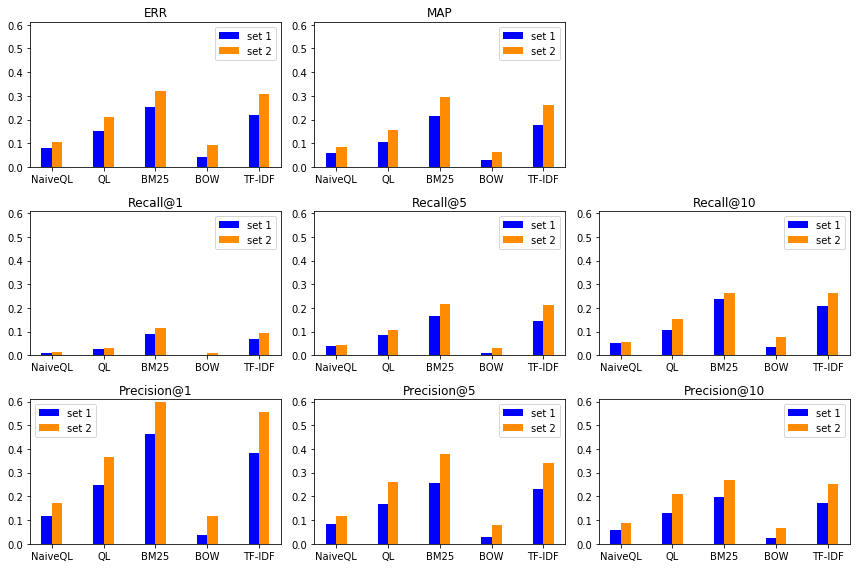

> PLOTS PER SEARCH METHOD
(y axes represent values corresponding to what is specified by the x labels)


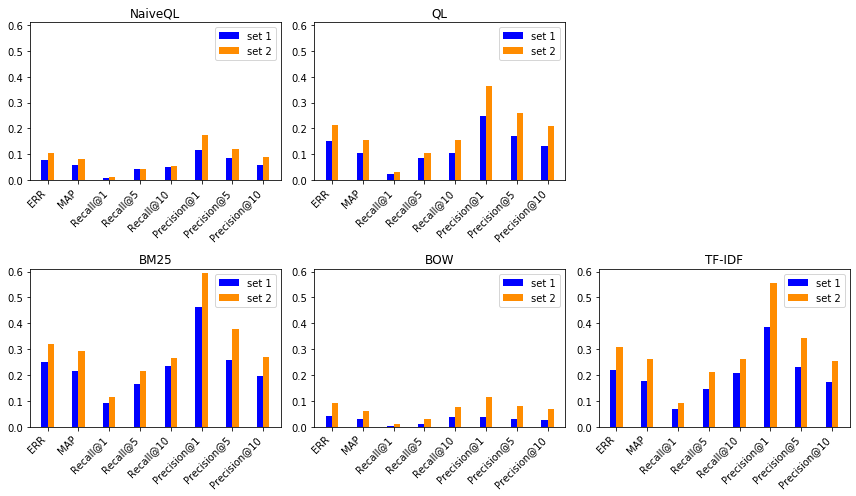

In [42]:
# TODO: Implement this! (20 points)

print("> PLOTS PER EVALUATION METHOD")
print("(y axes represent values corresponding to what is specified in the title)")
plt.figure(figsize=(12,8))
xticks = [search_fn for search_fn,_ in list_of_search_fns]
for plot_i, (eval_method,_) in enumerate(list_of_metrics):
    if plot_i > 1:
        plot_i+=1
    plt.subplot(3,3,plot_i+1)
    for index_set in index_sets:
        if index_set == 1:
            center = -0.1
            color = "blue"
        elif index_set == 2:
            center = +0.1
            color = "darkorange"
        for i, (search_fn,_) in enumerate(list_of_search_fns):
            label = None if i else f"set {index_set}"
            plt.title(eval_method)
            plt.bar(i+center,results[index_set][search_fn][eval_method], width=0.2, color=color,
                    align="center", label=label)
            plt.ylim(0,.61)
    plt.xticks(list(range(len(list_of_search_fns))), xticks)
    plt.legend()
    plt.tight_layout()
plt.show()

print("> PLOTS PER SEARCH METHOD")
print("(y axes represent values corresponding to what is specified by the x labels)")
plt.figure(figsize=(12,7))
xticks = [eval_method for eval_method,_ in list_of_metrics]
for plot_i, (search_fn,_) in enumerate(list_of_search_fns):
    if plot_i > 1:
        plot_i+=1
    plt.subplot(2,3,plot_i+1)
    for index_set in index_sets:
        if index_set == 1:
            center = -0.1
            color = "blue"
        elif index_set == 2:
            center = +0.1
            color = "darkorange"
        for i, (eval_method,_) in enumerate(list_of_metrics):
            label = None if i else f"set {index_set}"
            plt.title(search_fn)
            plt.bar(i+center,results[index_set][search_fn][eval_method], width=0.2, color=color,
                    align="center", label=label)
            plt.ylim(0,.61)
    plt.xticks(list(range(len(list_of_metrics))), xticks, rotation=45, horizontalalignment="right")
    plt.legend()
    plt.tight_layout()
plt.show()


Write a summary of what you observe in the results.
You summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      
*Hint*: You may build upon the answers from the previous sections. 

*TODO: Answer this!*



### Summary###
    
The results clearly show that the methods perform worse on the first index than on the second. This is expected, since stemming and stopword removal was applied to index two and not to index one, which should increase the chance of matching relevant documents. Out of all the methods we tested, BM25 outperforms all others for all evaluation metrics, with TF-IDF coming a close second. This matches our expectations, since the former is an improved version of the latter. Furthermore, as expected, the query likelihood model with smoothing shows better results for all metrics than the naive one, since the former prevents the probabilities from becoming zero. Generally, every metric shows the same order of performance for all approaches, with BM25 the best and BOW the worst model every time. Only for recall@10 and index two does the BOW approach perform a little better than Naive QL. For precision@10, BM25 and TF-IDF show very similar results which could be explained by the problem that precision@k does not express the quality of the order of retrieved documents. The results of precision@1 and precision@5 indicate that BM25 puts more relevant documents in the beginning than TF-IDF. One can also see that the recall score rises for all approaches with higher k and that precision decreases with higher k, which is natural since for low k all relevant documents cannot have been found yet. Regarding precision, the models are likely more confident about their results for low k but grow more uncertain with larger k.